In [2]:
import cortex
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import glob
import os
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from nilearn.plotting import view_img_on_surf
import nilearn
from tqdm import tqdm
import cepy

from helpers import * 


# testing stuff and helper functions

In [3]:
subject = 'sub-10159'
dat=[]
for hemi in ['L', 'R']:
    fn = f'{BIDS_DIR}/derivatives/fmriprep/{subject}/func/{subject}_task-rest_bold_space-fsaverage5.L.func.gii'
    gii = nib.load(fn)
    all_dat = np.stack([gii.darrays[ii].data for ii in range(len(gii.darrays))])
    dat.append(all_dat)


In [23]:
dat = np.concatenate(dat, 1)

In [55]:
dat.shape

(152, 20484)

In [4]:
view_img_on_surf?

Signature:
view_img_on_surf(
    stat_map_img,
    surf_mesh='fsaverage5',
    threshold=None,
    cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7fd0e9752750>,
    black_bg=False,
    vmax=None,
    vmin=None,
    symmetric_cmap=True,
    colorbar=True,
    colorbar_height=0.5,
    colorbar_fontsize=25,
    title=None,
    title_fontsize=25,
)
Docstring:
Insert a surface plot of a statistical map into an HTML page.

Parameters
----------
stat_map_img : Niimg-like object, 3D
    See http://nilearn.github.io/manipulating_images/input_output.html

surf_mesh : str or dict, optional.
    if 'fsaverage5', use fsaverage5 mesh from nilearn.datasets
    if 'fsaverage', use fsaverage mesh from nilearn.datasets
    if a dictionary, it should have the same structure as those returned by
    nilearn.datasets.fetch_surf_fsaverage, i.e. keys should be 'infl_left',
    'pial_left', 'sulc_left', 'infl_right', 'pial_right', and 'sulc_right',
    containing inflated and pial meshes, and sul

In [4]:
surf = nib.load(f'{BIDS_DIR}/derivatives/freesurfer/fsaverage5/surf/mh.inflated.gii')
annot = nilearn.surface.load_surf_data(f'{BIDS_DIR}/derivatives/freesurfer/fsaverage5/label/mh.HCPMMP1.annot') - 1

AttributeError: module 'nilearn' has no attribute 'surface'

In [ ]:
mean_data = get_mean_parcel_timeseries(dat, annot)

In [243]:
mean_data.shape

(360, 152)

In [ ]:
fsaverage_annot = nilearn.surface.load_surf_data(f'/mnt/d/bids/lateralization/derivatives/freesurfer/fsaverage/label/mh.HCPMMP1.annot') - 1

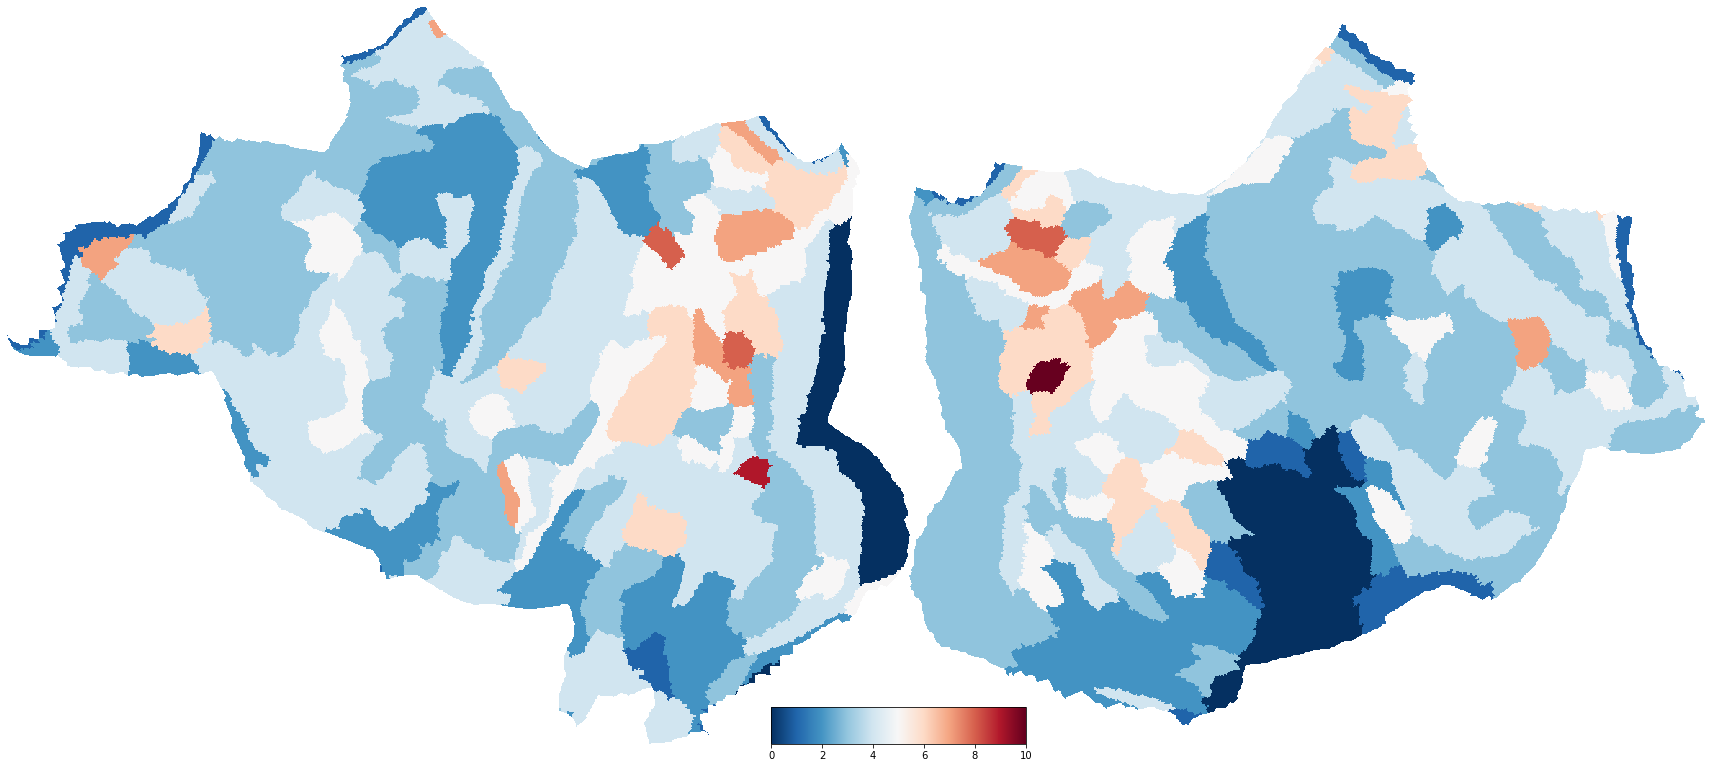

In [93]:

mapped_values = map_mean_parcels_to_surf(mean_data.std(1), fsaverage_annot)
surf = cortex.Vertex(mapped_values, subject='fsaverage', xfmname='standard')
cortex.quickshow(surf, with_rois=False, with_curvature=True, colorbar_location=[0.45, 0, 0.15, 0.05])
plt.show()

# load relevant dx and phenotypes

In [ ]:
all_phenotypes = {}

phenotype = pd.read_csv(f'{BIDS_DIR}/phenotype/bipolar_ii.tsv', sep='\t')
phenotypes = []
for sub in phenotype['participant_id']:
    if os.path.exists(f'{BIDS_DIR}/derivatives/fmriprep/{sub}/func/{sub}_task-rest_bold_space-fsaverage5.L.func.gii'):
        phenotypes.append(phenotype['bipollarii_sumscore'][phenotype['participant_id'] == sub].iloc[0])

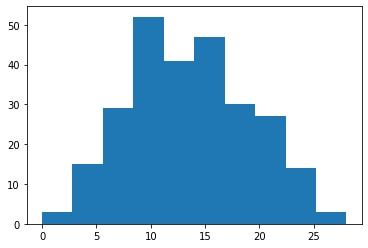

In [265]:
plt.hist(phenotypes)
plt.show()

# analyses based on mean activity in each region

In [248]:
X = []
subs=[]
for subject in tqdm(SUBJECTS):
    try:
        dat = []
        for hemi in ['L', 'R']:
            fn = f'{BIDS_DIR}/derivatives/fmriprep/{subject}/func/{subject}_task-rest_bold_space-fsaverage5.L.func.gii'
            gii = nib.load(fn)
            all_dat = np.stack([gii.darrays[ii].data for ii in range(len(gii.darrays))])
            dat.append(all_dat)
        dat = np.concatenate(dat, 1)
        mean_data = get_mean_parcel_timeseries(dat, annot).mean(1)
        X.append(mean_data)
        subs.append(subject)
    except Exception as e:
        print(e)
        print('continuing...')
X = np.stack(X)
np.save('mean_glasser.npy', X)
np.save('subs_with_restdat.npy', subs)

  1%|          | 3/265 [00:04<07:07,  1.63s/it]

No such file or no access: '/mnt/d/bids/ds000030/derivatives/fmriprep/sub-10193/func/sub-10193_task-rest_bold_space-fsaverage5.L.func.gii'
continuing...


 33%|███▎      | 87/265 [03:41<07:16,  2.45s/it]

No such file or no access: '/mnt/d/bids/ds000030/derivatives/fmriprep/sub-10948/func/sub-10948_task-rest_bold_space-fsaverage5.L.func.gii'
continuing...


 41%|████      | 108/265 [04:25<04:20,  1.66s/it]

No such file or no access: '/mnt/d/bids/ds000030/derivatives/fmriprep/sub-11082/func/sub-11082_task-rest_bold_space-fsaverage5.L.func.gii'
continuing...


 85%|████████▍ | 225/265 [08:39<01:41,  2.53s/it]

No such file or no access: '/mnt/d/bids/ds000030/derivatives/fmriprep/sub-70002/func/sub-70002_task-rest_bold_space-fsaverage5.L.func.gii'
continuing...


100%|██████████| 265/265 [10:07<00:00,  2.29s/it]


In [ ]:
X = np.load('mean_glasser.npy')
subs = np.load('subs_with_restdat.npy')
X = scipy.stats.zscore(X, 1)
phenotypes = np.array(phenotypes)

## PCA

In [277]:
pca_sol = PCA().fit(X)
all_PCs = pca_sol.transform(X)

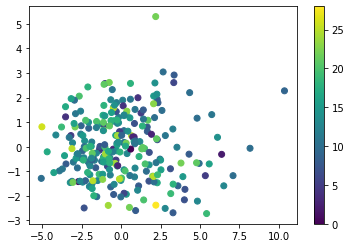

In [278]:
plt.scatter(PCs[:,0], PCs[:,1], c=phenotypes)
plt.colorbar()
plt.show()

### single PC corrs

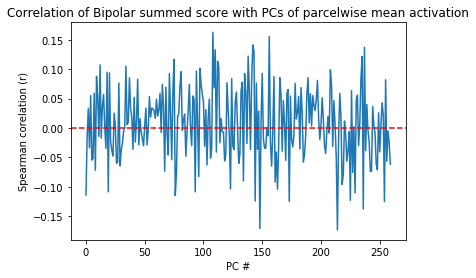

In [340]:
corrs = []
for pc in range(260):
    PC = all_PCs[:,pc]
    corrs.append(spearmanr(phenotypes, PC)[0])
os.makedirs('figures', exist_ok=True)
plt.plot(corrs)
plt.title('Correlation of Bipolar summed score with PCs of parcelwise mean activation')
plt.xlabel('PC #')
plt.ylabel('Spearman corelation (r)')
plt.axhline(0,0,1,color='r',linestyle='--')
plt.savefig('figures/bipolar_meanact_PC_corrs.png', dpi=200, bbox_inches='tight')
plt.show()

### PCR

In [336]:
corrs = []
weights = []
for n_pcs in range(1,260):
    kfold = KFold(3)
    PCs = all_PCs[:,:n_pcs]
    these_corrs = []
    these_weights = []
    for train_inds, test_inds in kfold.split(PCs):
        X_train = PCs[train_inds]
        X_test = PCs[test_inds]
        model = RidgeCV(alphas=np.logspace(-4,4,num=9)).fit(X_train, phenotypes[train_inds])
        preds = model.predict(X_test)
        true = phenotypes[test_inds]
        these_corrs.append(spearmanr(true, preds)[0])
        these_weights.append(model.coef_)
    corrs.append(np.mean(these_corrs))
    weights.append(np.mean(these_weights,0))

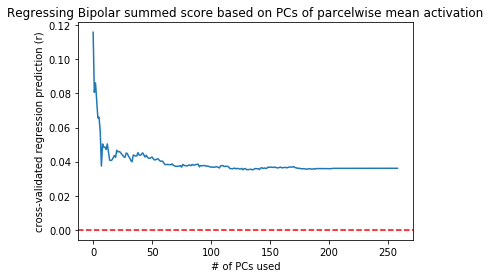

In [337]:
os.makedirs('figures', exist_ok=True)
plt.plot(corrs)
plt.title('Regressing Bipolar summed score based on PCs of parcelwise mean activation')
plt.xlabel('# of PCs used')
plt.ylabel('cross-validated regression prediction (r)')
plt.axhline(0,0,1,color='r',linestyle='--')
plt.savefig('figures/bipolar_meanact_PCR.png', dpi=200, bbox_inches='tight')
plt.show()

## visualize the first PC of activation, since it is predictive

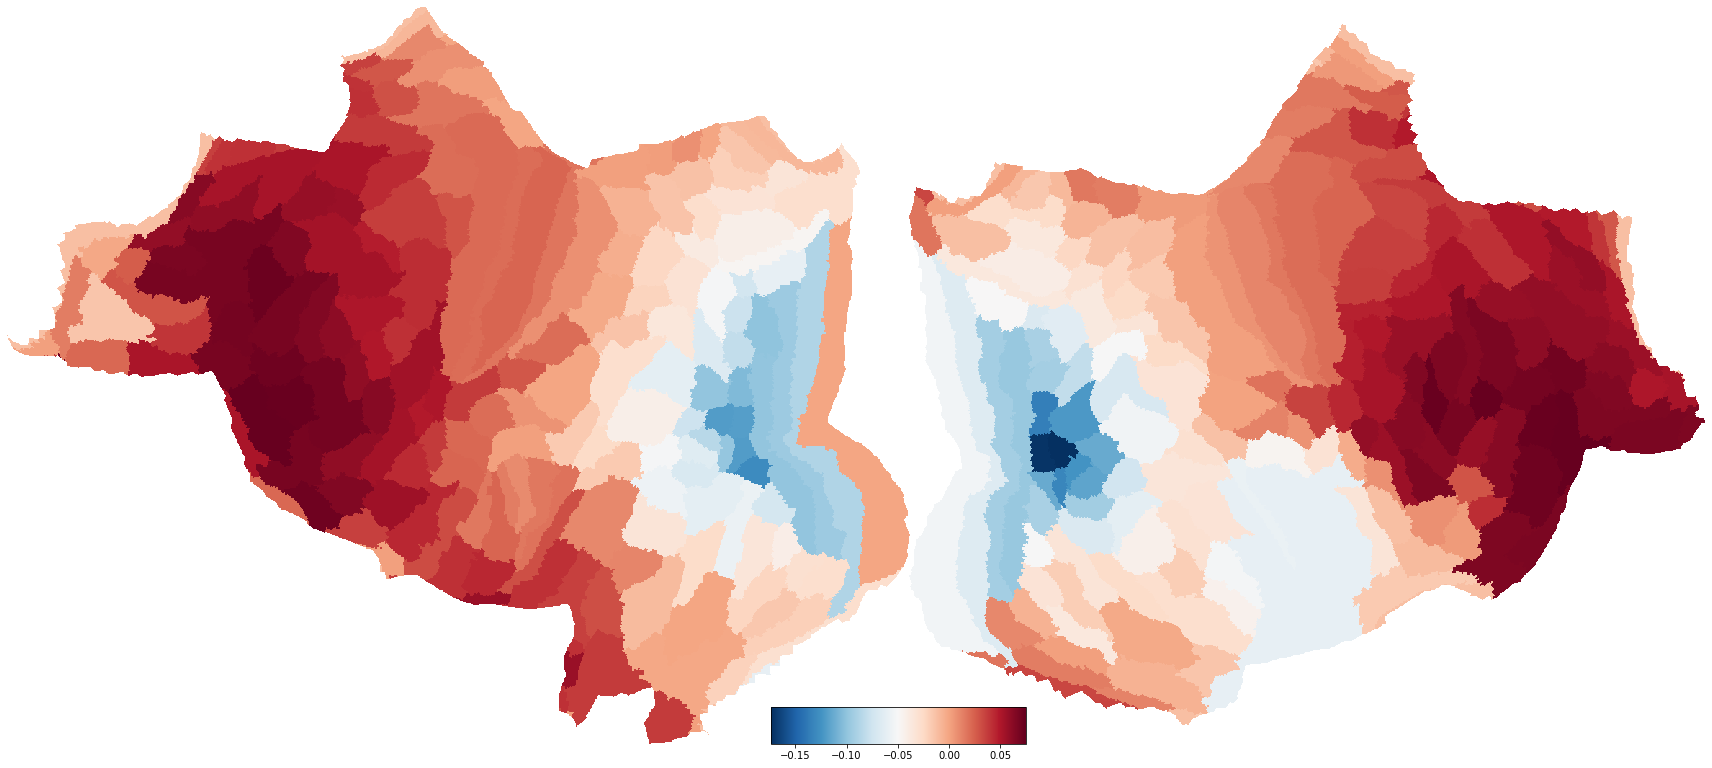

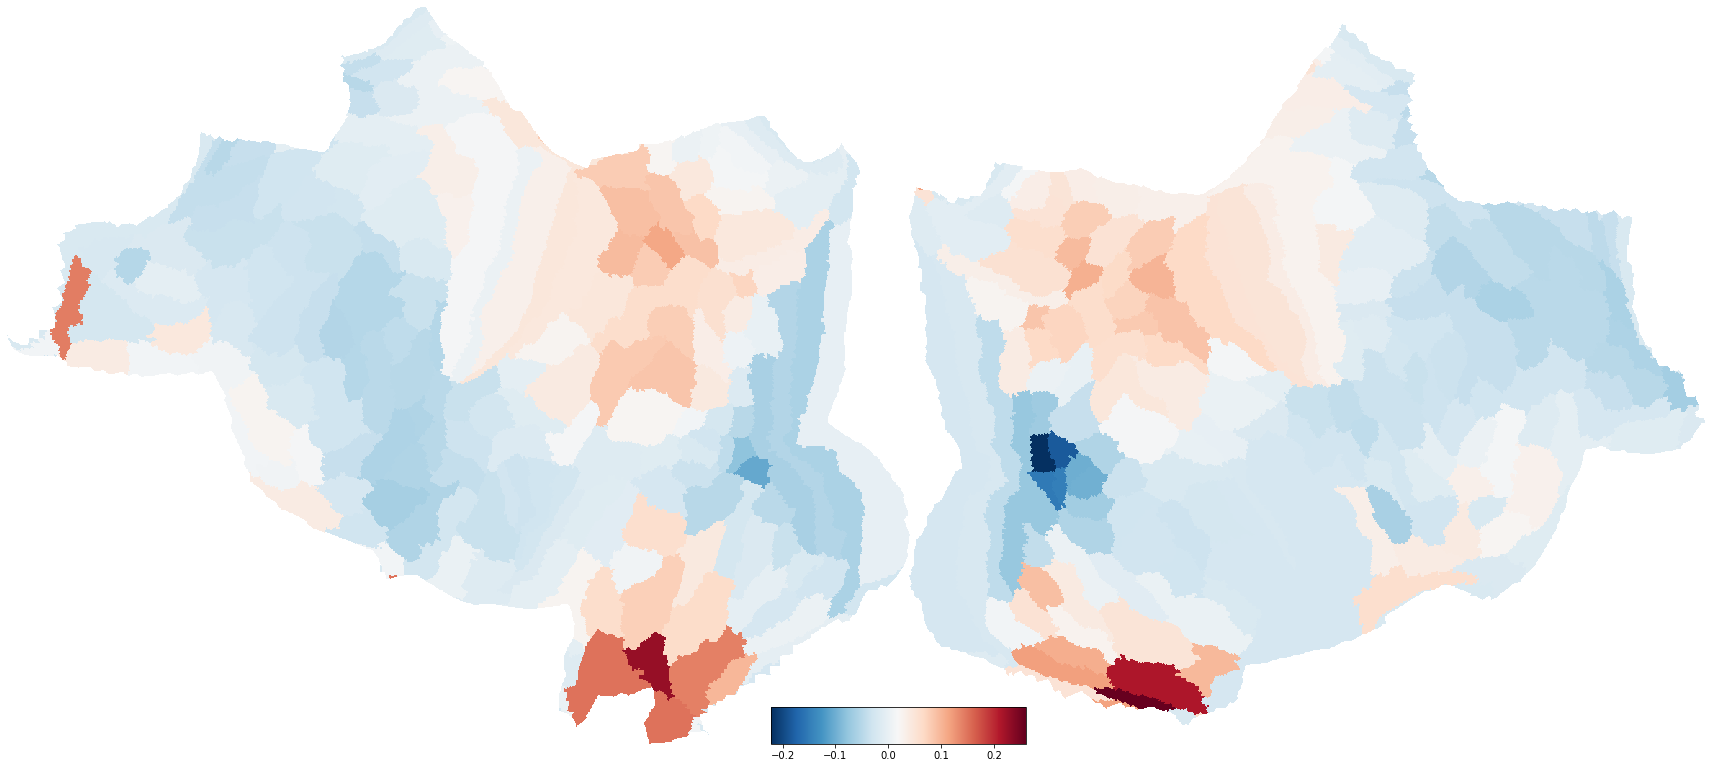

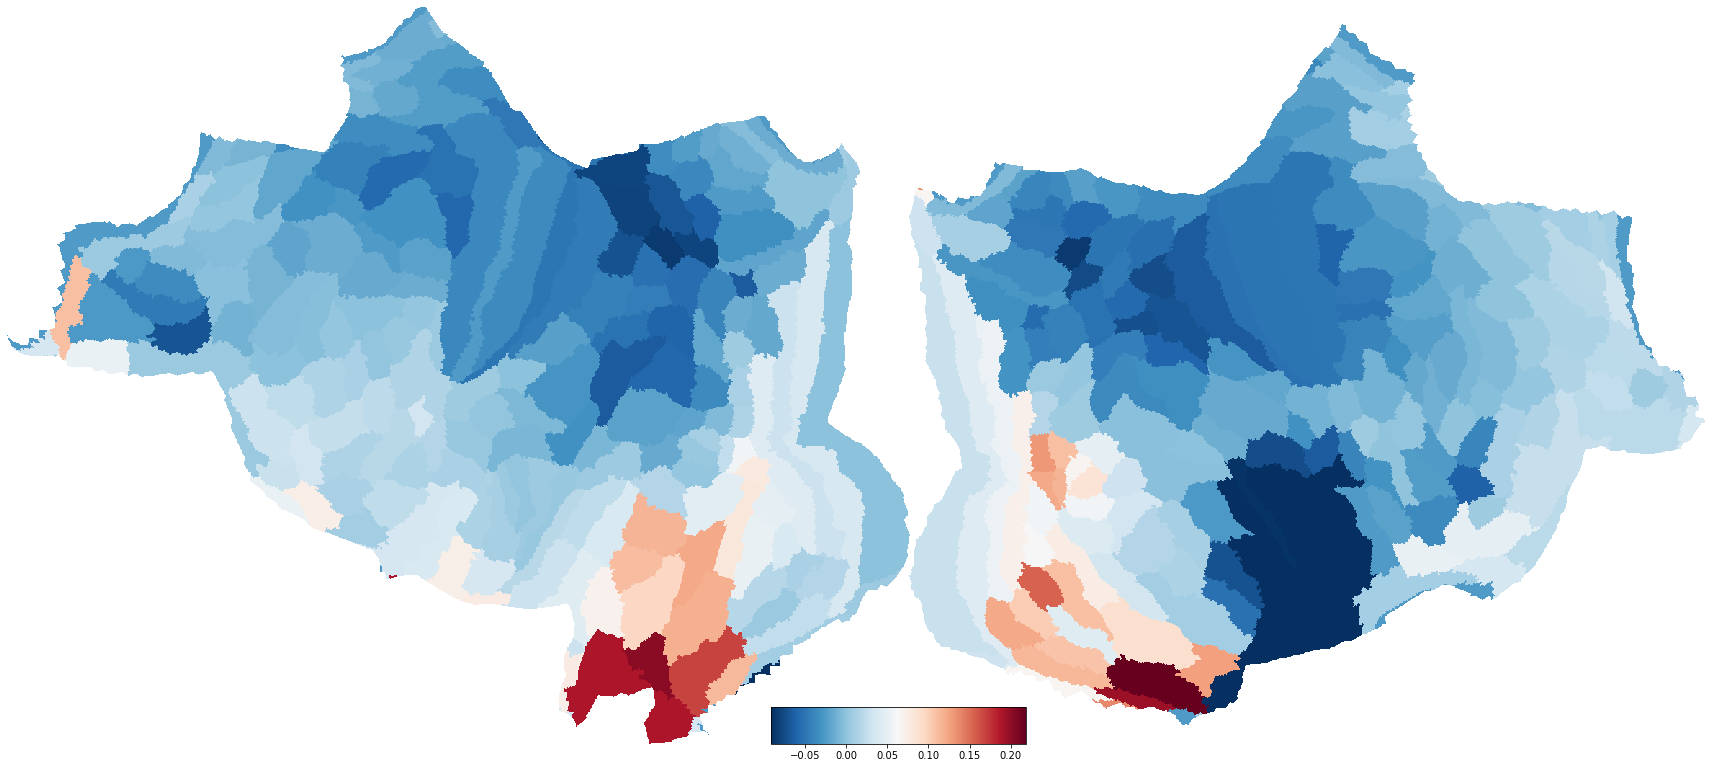

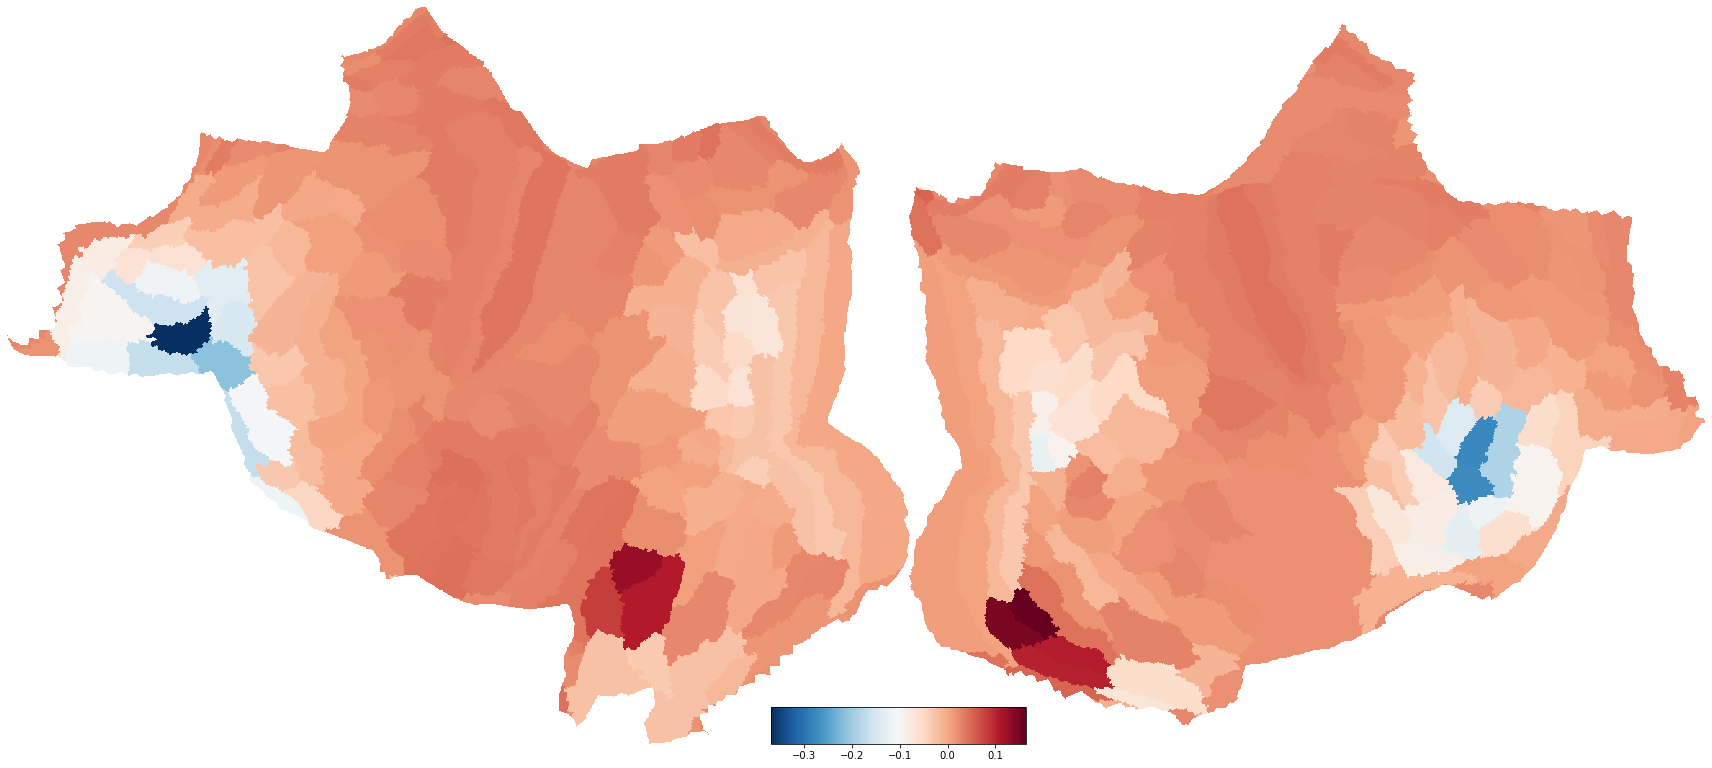

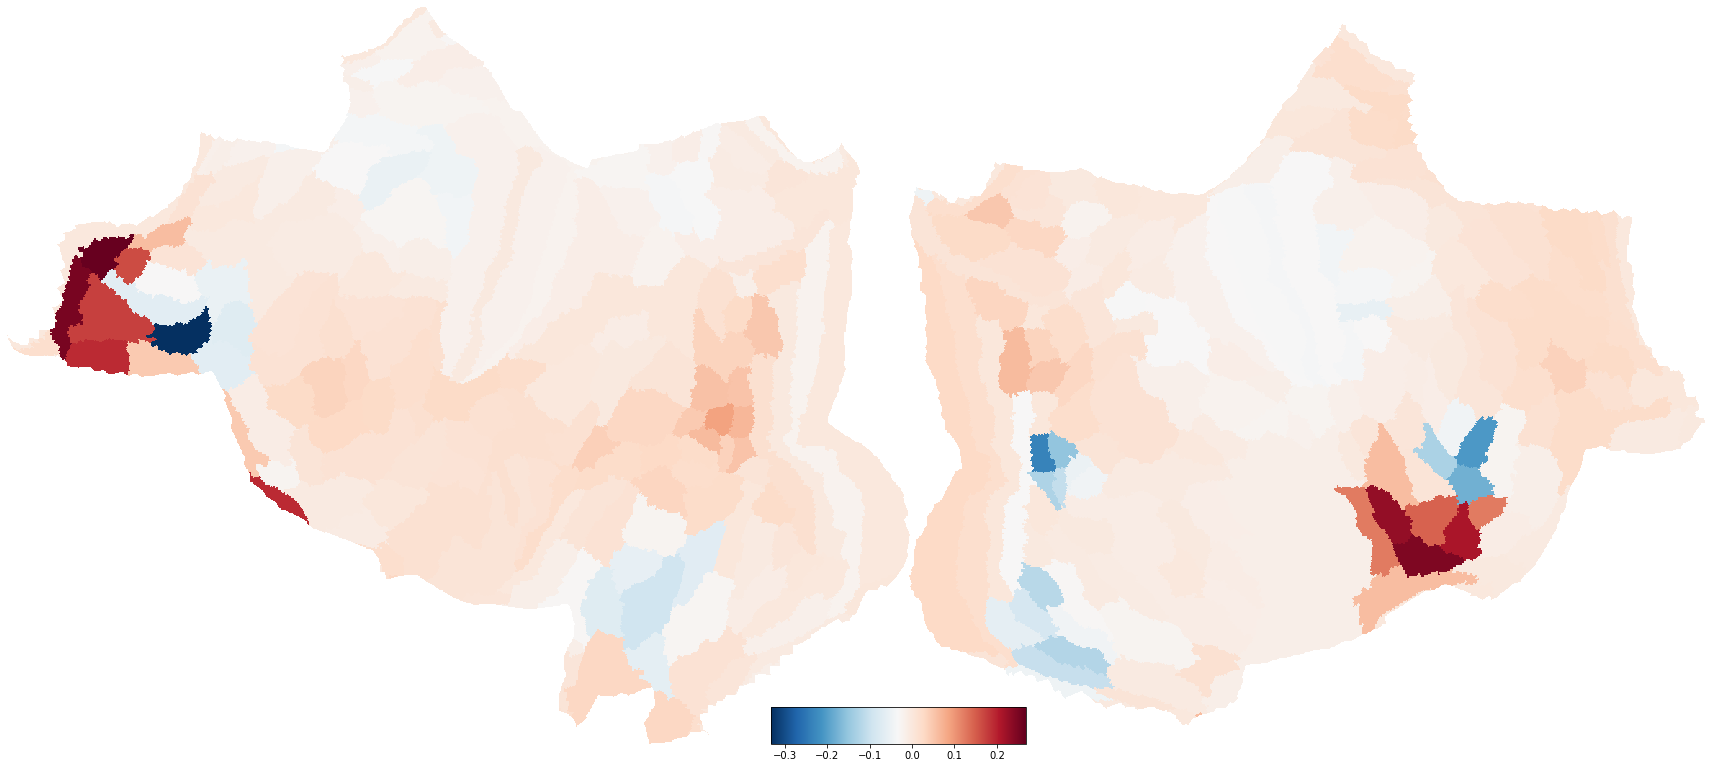

In [322]:
for pc in range(5):
    mapped_values = map_mean_parcels_to_surf(pca_sol.components_[pc,:], fsaverage_annot)
    surf = cortex.Vertex(mapped_values, subject='fsaverage', xfmname='standard')
    cortex.quickshow(surf, with_rois=False, with_curvature=True, colorbar_location=[0.45, 0, 0.15, 0.05])
    plt.savefig(f'figures/meanact_PC-{pc+1}_weights.png')
    plt.show()

# analyses based on raw FC matrices

In [130]:
confounds = get_subject_confounds(subject)
# we wrap data in a list and select the first output element, as the function expects multiple subjects (kind of dumb...)
conn = ConnectivityMeasure(kind='correlation').fit_transform([mean_data.T])[0]
conn[conn==1] = .9999
conn[conn==-1] = -.9999
conn_z = .5*np.log((1+conn)/(1-conn))

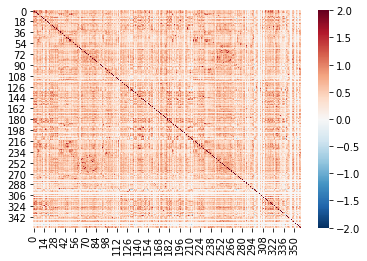

In [129]:
import seaborn as sns
sns.heatmap(conn_z, center=0, cmap='RdBu_r', vmin=-2, vmax=2)

In [11]:

# SUBJECTS = [os.path.basename(folder) for folder in glob.glob(f'{BIDS_DIR}/derivatives/fmriprep/*')]
SUBJECTS = np.load('subs_with_restdat.npy')

In [231]:

connectomes = []
for sub in tqdm(SUBJECTS):
    try:
        connectomes.append(get_subject_connectome(sub, overwrite=False))
    except Exception as e:
        print(e)

  1%|          | 3/265 [00:13<20:51,  4.78s/it]

No such file or no access: '/mnt/d/bids/ds000030/derivatives/fmriprep/sub-10193/func/sub-10193_task-rest_bold_space-fsaverage5.L.func.gii'


/home/nblauch/anaconda3/envs/pycortex/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
 33%|███▎      | 87/265 [06:43<15:31,  5.23s/it]

No such file or no access: '/mnt/d/bids/ds000030/derivatives/fmriprep/sub-10948/func/sub-10948_task-rest_bold_space-fsaverage5.L.func.gii'


/home/nblauch/anaconda3/envs/pycortex/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
 41%|████      | 108/265 [08:10<15:08,  5.79s/it]

No such file or no access: '/mnt/d/bids/ds000030/derivatives/fmriprep/sub-11082/func/sub-11082_task-rest_bold_space-fsaverage5.L.func.gii'


/home/nblauch/anaconda3/envs/pycortex/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
 85%|████████▌ | 226/265 [17:09<01:51,  2.86s/it]

No such file or no access: '/mnt/d/bids/ds000030/derivatives/fmriprep/sub-70002/func/sub-70002_task-rest_bold_space-fsaverage5.L.func.gii'


/home/nblauch/anaconda3/envs/pycortex/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 265/265 [20:06<00:00,  4.55s/it]


In [232]:
connectomes = np.stack(connectomes)

In [233]:
connectomes[np.isnan(connectomes)] = 0
connectomes[np.isinf(connectomes)] = 10
connectomes[np.isinf(-connectomes)] = -10

In [255]:
np.save('connectomes.npy', connectomes)

In [6]:
connectomes = np.load('connectomes.npy')
X = connectomes.reshape(connectomes.shape[0],-1)

## PCA and clustering
begin to visualize some phenotypes

In [342]:
pca_sol = PCA().fit(X)
all_PCs = pca_sol.transform(X)

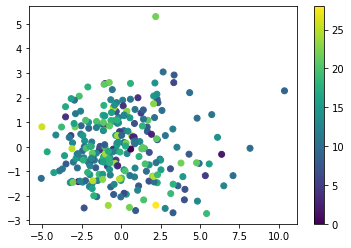

In [343]:
plt.scatter(PCs[:,0], PCs[:,1], c=phenotypes)
plt.colorbar()
plt.show()

### single PC corrs

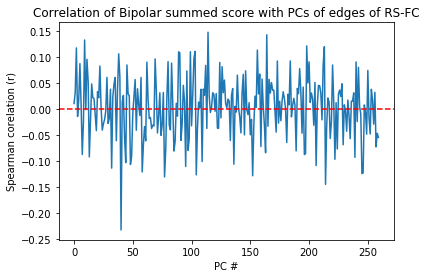

In [344]:
corrs = []
for pc in range(260):
    PC = all_PCs[:,pc]
    corrs.append(spearmanr(phenotypes, PC)[0])
os.makedirs('figures', exist_ok=True)
plt.plot(corrs)
plt.title('Correlation of Bipolar summed score with PCs of edges of RS-FC')
plt.xlabel('PC #')
plt.ylabel('Spearman corelation (r)')
plt.axhline(0,0,1,color='r',linestyle='--')
plt.savefig('figures/bipolar_RSFC-edges_PC_corrs.png', dpi=200, bbox_inches='tight')
plt.show()

### PCR

In [345]:
corrs = []
weights = []
for n_pcs in range(1,260):
    kfold = KFold(3)
    PCs = all_PCs[:,:n_pcs]
    these_corrs = []
    these_weights = []
    for train_inds, test_inds in kfold.split(PCs):
        X_train = PCs[train_inds]
        X_test = PCs[test_inds]
        model = RidgeCV(alphas=np.logspace(-4,4,num=9)).fit(X_train, phenotypes[train_inds])
        preds = model.predict(X_test)
        true = phenotypes[test_inds]
        these_corrs.append(spearmanr(true, preds)[0])
        these_weights.append(model.coef_)
    corrs.append(np.mean(these_corrs))
    weights.append(np.mean(these_weights,0))

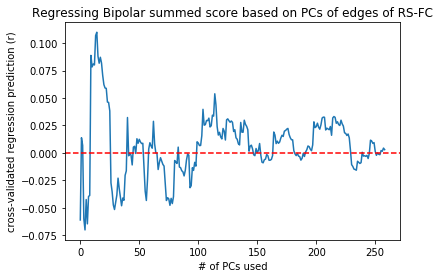

In [346]:
os.makedirs('figures', exist_ok=True)
plt.plot(corrs)
plt.title('Regressing Bipolar summed score based on PCs of edges of RS-FC')
plt.xlabel('# of PCs used')
plt.ylabel('cross-validated regression prediction (r)')
plt.axhline(0,0,1,color='r',linestyle='--')
plt.savefig('figures/bipolar_RSFC-edges_PCR.png', dpi=200, bbox_inches='tight')
plt.show()

# results based on connectome embedding

In [8]:
sparsity = .3
abs_val_connectomes = np.abs(connectomes)
abs_val_connectomes[abs_val_connectomes < np.percentile(abs_val_connectomes, 1-sparsity)] = 0

In [9]:
group_connectome = np.mean(abs_val_connectomes, 0)
group_connectome = np.maximum(group_connectome, group_connectome.T)
ce_group = cepy.CE(permutations=1,seed=1)
ce_group.fit(group_connectome)
cosine_sim = ce_group.similarity()

Start training  1  word2vec models on  1 threads.


In [12]:
os.makedirs(f'{BIDS_DIR}/derivatives/python/cepy', exist_ok=True)
for sub_i, sub in tqdm(enumerate(SUBJECTS)):
    sub_conn = abs_val_connectomes[sub_i]
    sub_conn = np.maximum(sub_conn, sub_conn.T)
    ce_sub = cepy.CE(permutations=1,seed=1)
    ce_sub.fit(sub_conn)
    ce_sub.save_model(f'{BIDS_DIR}/derivatives/python/cepy/{sub}_ce.json')
    ce_sub_aligned = cepy.align(ce_group, ce_sub)
    ce_sub_aligned.save_model(f'{BIDS_DIR}/derivatives/python/cepy/{sub}_ce_aligned.json')

0it [00:00, ?it/s]

Start training  1  word2vec models on  1 threads.


0it [15:10, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/lab_data/behrmannlab/bids/lateralization/derivatives/python/cepy/sub-10159_ce.json'

In [ ]:
# now load into matrix
ce_weights = []
for sub_i, sub in enumerate(tqdm(SUBJECTS)):
    ce_sub_aligned = cepy.load_model(f'/lab_data/behrmannlab/bids/lateralization/derivatives/python/cepy/sub-{sub:02d}_ce_aligned.json')
    weight = ce_sub_aligned.weights.get_w_mean(norm = True)
    ce_weights.append(weight.reshape(-1))
ce_weights = np.array(ce_weights)

# more plotting

In [44]:
dat_map = np.nanmean(dat, 0, )

# fsaverage5 = nilearn.datasets.fetch_surf_fsaverage('fsaverage5')
# merged = np.concatenate(fsaverage5['pial_left'])
plotting.view_surf(
    f'{BIDS_DIR}/derivatives/freesurfer/fsaverage5/surf/mh.inflated.gii',
    dat_map, 
    threshold=0.0001, 
                  )

In [ ]:
dat_map = dat.mean(0)
surf = cortex.Vertex(dat_map, subject='fsaverage5', xfmname='standard')
cortex.quickshow(surf, with_rois=False, with_curvature=True, colorbar_location=[0.45, 0, 0.15, 0.05])
plt.title(domain)
plt.tight_layout()
plt.show()